# Republican Caucus General Market Activity

This notebook creates Figures 1 and 4 and Table 2.

In [1]:
import os
import sys
import re

from itertools import *
from operator import mul
from functools import reduce
import pickle

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

idx = pd.IndexSlice

from research_tools import storage

pd.options.display.float_format = lambda x: '{:,.4f}'.format(x) if abs(x) < 1 else '{:,.2f}'.format(x)

In [2]:
os.chdir('..')

basename = 'gop'

orders, behavior_analysis, trader_analysis, quotes_dict = storage.retrieve_all(
    [basename + '.orders',
     basename + '.behavior_analysis',
     basename + '.trader_analysis',
     basename + '.reconstructed_quotes'])

Reading data from data/gop.orders.p
Reading data from data/gop.behavior_analysis.p
Reading data from data/gop.trader_analysis.p
Reading data from data/gop.reconstructed_quotes.p


# Plot Prices

This chart is for Figure 4.

In [3]:
quotes_dict.keys()

dict_keys([960, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 1229, 959])

In [4]:
contract_names = {960: 'Donald Trump',
                  616: 'Jeb Bush',
                  617: 'Ben Carson',
                  618: 'Chris Christie',
                  619: 'Ted Cruz',
                  620: 'Huckabee',
                  621: 'Jindal',
                  622: 'Paul',
                  623: 'Perry',
                  624: 'Rubio',
                  625: 'Santorum',
                  626: 'Walker',
                  1229: 'Fiorina',
                  959: 'Kasich'}

contract_names2 = {960: 'Trump',
                   616: 'Bush',
                   617: 'Carson',
                   618: 'Christie',
                   619: 'Cruz',
                   620: 'Huckabee',
                   621: 'Jindal',
                   622: 'Paul',
                   623: 'Perry',
                   624: 'Rubio',
                   625: 'Santorum',
                   626: 'Walker',
                   1229: 'Fiorina',
                   959: 'Kasich'}

In [5]:
def plot_prices(xlim=None, contracts=None, title=None):
    if not contracts:
        contracts = quotes_dict.keys()

    n = len(contracts)
    fig = plt.figure(figsize=(7.5, 1.875 * n))

    if title:
        plt.suptitle(title)

    for i, c_id in enumerate(contracts):
        df = quotes_dict[c_id]
        df['mid price'] = df[['bid_price', 'ask_price']].mean(axis=1)

        ax = plt.subplot(n, 1, i + 1)
        df.plot(x='timestamp', y='mid price', ax=ax, c='black', sharex=ax, label=c_id)
        plt.ylim([0, 1])
        plt.grid(True)
        plt.legend([contract_names2[c_id] + ' price'])
        
        if xlim:
            plt.xlim([pd.Timestamp(xlim), pd.Timestamp('2016.02.02 14:00', tz='US/Eastern')])        

    plt.xlabel('Date')

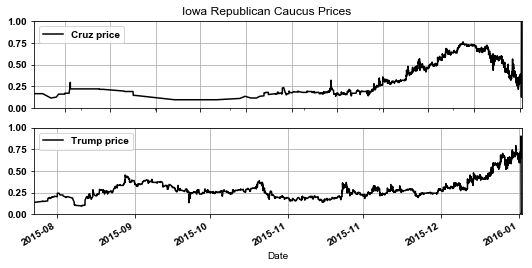

In [6]:
font = {'family' : 'Arial',
        'weight' : 'bold',
        'size'   : 10}

mpl.rc('font', **font)

plot_prices(contracts=[619, 960], title='Iowa Republican Caucus Prices')

plt.tight_layout(rect=(0, 0, 1, 0.98))

plt.savefig('charts/rep_caucus_prices.png', dpi=300)

In [7]:
trader_analysis['day_of_trade'] = trader_analysis.date_executed.dt.date

daily_activity = trader_analysis.groupby('day_of_trade')[['quantity', 'notional']].sum()
daily_activity.index = pd.to_datetime(daily_activity.index)
daily_activity2 = daily_activity['2016-01-01':]

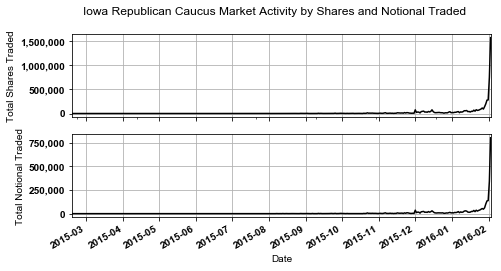

In [8]:
plt.figure(figsize=(7.5, 3.75))

plt.suptitle('Iowa Republican Caucus Market Activity by Shares and Notional Traded')

ax1 = plt.subplot(2, 1, 1)
daily_activity['quantity'].plot(c='k', ax=ax1, label='Shares Traded')
plt.xlabel('Date')
plt.ylabel('Total Shares Traded')
ax1.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.grid(True)

ax2 = plt.subplot(2, 1, 2)
daily_activity['notional'].plot(c='k', ax=ax2, label='Shares Traded', sharex=ax1)
plt.xlabel('Date')
plt.ylabel('Total Notional Traded')
ax2.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.grid(True)

# Per-contract Volume Activity

This shows the popular contracts. It is Table 2 in the paper.

In [9]:
out = trader_analysis.groupby('contract_id')[['quantity', 'notional']].sum()
out.index = [contract_names2[x] for x in out.index]

out.sort_values('notional', ascending=False, inplace=True)

print(out.to_latex())
out

\begin{tabular}{lrr}
\toprule
{} &  quantity &   notional \\
\midrule
Trump    &   1504976 & 755,815.48 \\
Cruz     &   1315862 & 663,317.44 \\
Paul     &    834450 & 421,771.84 \\
Rubio    &    957920 & 411,231.44 \\
Carson   &    685058 & 315,323.40 \\
Huckabee &    182680 &  76,436.52 \\
Bush     &    168766 &  67,130.60 \\
Christie &    101940 &  49,189.62 \\
Santorum &     78572 &  39,330.02 \\
Fiorina  &     69442 &  32,976.98 \\
Kasich   &     59502 &  30,317.42 \\
Jindal   &     35196 &  16,366.44 \\
Walker   &     17804 &  10,900.46 \\
Perry    &      4302 &   2,182.70 \\
\bottomrule
\end{tabular}



,quantity,notional
Trump,1504976,"755,815.48"
Cruz,1315862,"663,317.44"
Paul,834450,"421,771.84"
Rubio,957920,"411,231.44"
Carson,685058,"315,323.40"
Huckabee,182680,"76,436.52"
Bush,168766,"67,130.60"
Christie,101940,"49,189.62"
Santorum,78572,"39,330.02"
Fiorina,69442,"32,976.98"


Total market activity and fees

In [10]:
trader_analysis[['quantity', 'notional', 'fee']].sum()

quantity   6,016,470.00
notional   2,892,290.36
fee           23,096.63
dtype: float64

By-trader metrics

In [11]:
trader_analysis.groupby('user_guid')[['quantity', 'notional', 'gross_pnl', 'fee', 'pnl_net_fee']].sum().describe()

,quantity,notional,gross_pnl,fee,pnl_net_fee
count,"4,452.00","4,452.00","4,452.00","4,452.00","4,452.00"
mean,"1,351.41",649.66,-0.0000,5.19,-5.19
std,"6,610.83","3,407.04",224.30,20.01,211.91
min,2.00,0.0100,"-1,698.95",0.0000,"-1,701.32"
25%,28.00,10.05,-10.30,0.0000,-10.54
50%,100.00,37.50,-0.1400,0.1295,-0.2500
75%,546.50,197.25,8.86,1.65,7.35
max,"241,090.00","157,704.08","3,202.22",320.22,"2,882.00"


By-trader metrics

In [12]:
behavior_analysis[['max_loss', 'max_in_pool', 'pnl']].describe()

,max_loss,max_in_pool,pnl
count,"4,452.00","4,452.00","4,452.00"
mean,121.19,122.24,-5.19
std,273.79,278.95,211.91
min,0.0100,0.0100,"-1,701.32"
25%,5.80,5.80,-10.54
50%,18.19,18.24,-0.2500
75%,78.42,79.01,7.35
max,"2,618.78","2,334.54","2,882.00"


Total amount of capital risked by traders

In [13]:
behavior_analysis[['max_loss', 'max_in_pool']].sum()

max_loss      539,537.93
max_in_pool   544,205.11
dtype: float64

# Sum of midquotes charts

This chart is Figure 1.

In [14]:
def make_interval_quotes(df):
    df = df.set_index('timestamp')

    start = df.index[0].floor('1Min')
    end = df.index[-1].floor('1Min')

    timestamp_intervals = pd.date_range(start, end, freq='1Min')

    return df[['bid_price', 'ask_price']].apply(lambda x: x.asof(timestamp_intervals)).bfill()

def make_quote_panel(quotes):
    quotes_intervals = {c_id: make_interval_quotes(df) for c_id, df in quotes.items()}

    start = min([df.index[0] for df in quotes_intervals.values()])
    end = max([df.index[-1] for df in quotes_intervals.values()])
    timestamp_intervals = pd.date_range(start, end, freq='1Min')

    panel = Panel({c_id: df.loc[timestamp_intervals].ffill() for c_id, df in quotes_intervals.items()})
    
    return panel

In [15]:
quote_panel = make_quote_panel(quotes_dict)

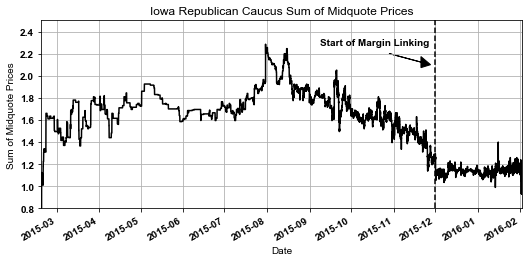

In [16]:
plt.figure(figsize=(7.5, 3.75))

ax1 = plt.gca()

quote_panel.mean(axis=2).sum(axis=1).plot(c='k', ax=ax1)
plt.title('Iowa Republican Caucus Sum of Midquote Prices')
plt.ylim([0.8, 2.5])
plt.vlines(x=[pd.Timestamp('2015-12-01')], ymin=0.8, ymax=2.5, linestyles='dashed')
plt.text(pd.Timestamp('2015-11-27'), 2.3, 'Start of Margin Linking',
         horizontalalignment='right', verticalalignment='center')
plt.arrow(x=pd.Timestamp('2015-10-29'), y=2.2, dx=30, dy=-0.1,
          length_includes_head=True, head_width=0.1, head_length=7, color='k')
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Sum of Midquote Prices')

plt.tight_layout()

plt.savefig('charts/rep_sum_midquotes.png', dpi=300)